In [1]:
import csv
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale,robust_scale,minmax_scale,maxabs_scale
import datetime
from dateutil.parser import parse
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew

# 데이터 파악 및 누락값 채우기

In [2]:
data='./training.csv'
train=pd.read_csv(data,header=0)
train=pd.DataFrame(data=train)

# 중복 데이터 삭제와 결측 데이터 채우기

In [3]:
train=train.drop(["VehYear"],axis=1)
train=train.drop(["RefId"],axis=1)
train=train.drop(["Model"],axis=1)
train=train.drop(["Trim"],axis=1)
train=train.drop(["SubModel"],axis=1)
train=train.drop(["WheelTypeID"],axis=1)
train=train.drop(["PRIMEUNIT"],axis=1)
train=train.drop(["AUCGUART"],axis=1)
train=train.drop(["VNZIP1"],axis=1)
train=train.drop(["PurchDate"],axis=1)
train=train.drop(["BYRNO"],axis=1)


In [4]:
train.isnull().sum()

IsBadBuy                                0
Auction                                 0
VehicleAge                              0
Make                                    0
Color                                   8
Transmission                            9
WheelType                            3174
VehOdo                                  0
Nationality                             5
Size                                    5
TopThreeAmericanName                    5
MMRAcquisitionAuctionAveragePrice      18
MMRAcquisitionAuctionCleanPrice        18
MMRAcquisitionRetailAveragePrice       18
MMRAcquisitonRetailCleanPrice          18
MMRCurrentAuctionAveragePrice         315
MMRCurrentAuctionCleanPrice           315
MMRCurrentRetailAveragePrice          315
MMRCurrentRetailCleanPrice            315
VNST                                    0
VehBCost                                0
IsOnlineSale                            0
WarrantyCost                            0
dtype: int64

In [5]:
train.loc[[15906, 24567, 24578, 70432, 70434, 70437, 70445, 70446, 70450],["Transmission"]]="AUTO"

train.dropna(subset=["Color"], inplace=True)
train.dropna(subset=["MMRAcquisitionAuctionAveragePrice"], inplace=True)
train.dropna(subset=["MMRCurrentAuctionAveragePrice"], inplace=True)
train.dropna(subset=["Size"], inplace=True)
train.loc[train["WheelType"].isnull(),"WheelType"]="Alloy"
train.loc[train['Transmission']=="Manual","Transmission"]="MANUAL"

In [6]:
numerical_features = train.select_dtypes(include=["float64","int64","bool"]).columns.values
categorical_features = train.select_dtypes(include=["object"]).columns.values

In [7]:
numerical_features

array(['IsBadBuy', 'VehicleAge', 'VehOdo',
       'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
       'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice',
       'VehBCost', 'IsOnlineSale', 'WarrantyCost'], dtype=object)

In [8]:
categorical_features

array(['Auction', 'Make', 'Color', 'Transmission', 'WheelType',
       'Nationality', 'Size', 'TopThreeAmericanName', 'VNST'], dtype=object)

In [9]:
# 카테고리와 연속 변수 분류
index=[0,12]
numerical_features=np.delete(numerical_features,index)
categorical_features=np.append(categorical_features,["IsBadBuy"])
categorical_features=np.append(categorical_features,["IsOnlineSale"])

# 데이터 분포 파악  데이터 변수 축소

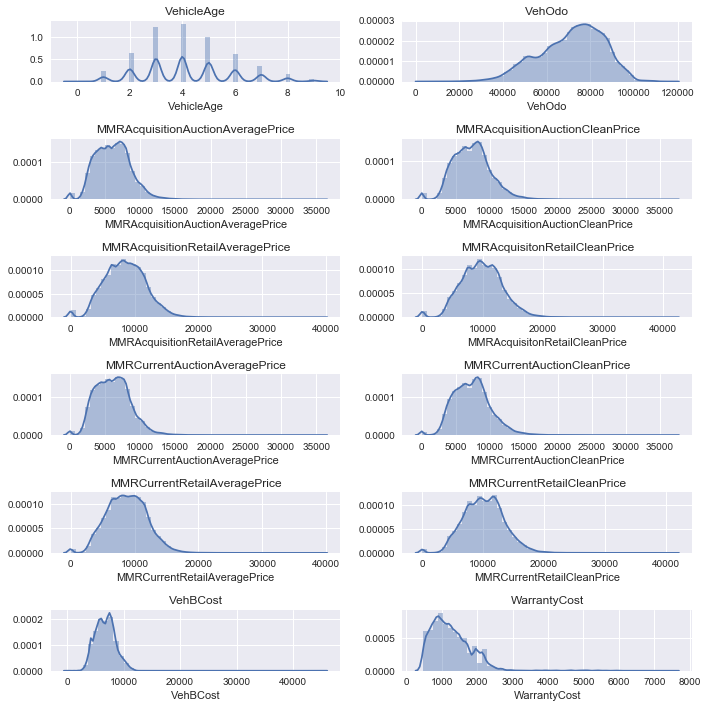

In [10]:
lst=list(train[numerical_features])

plt.figure(figsize=(10,10))
for i in range(12):
   
    plt.subplot(6,2,i+1)
    sns.distplot(train[lst[i]])
    plt.title(lst[i])
plt.tight_layout()
plt.show()




In [11]:
num_col=['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
                        'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
                        'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
                        'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice']

In [12]:
train_x=train.copy()
train_y=train["IsBadBuy"].copy()
train_x["AuctionAve"]=sum(train[a] for a in num_col)/len(num_col)
train_x=train_x.drop(num_col,axis=1)

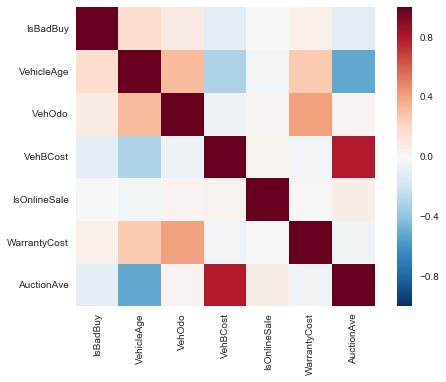

In [13]:
x_cor=train_x.corr()
sns.heatmap(x_cor,square=True)
plt.show()

In [14]:
train_x.columns

Index(['IsBadBuy', 'Auction', 'VehicleAge', 'Make', 'Color', 'Transmission',
       'WheelType', 'VehOdo', 'Nationality', 'Size', 'TopThreeAmericanName',
       'VNST', 'VehBCost', 'IsOnlineSale', 'WarrantyCost', 'AuctionAve'],
      dtype='object')

In [15]:
category_col=["Auction","Make","Color","Transmission","WheelType","Nationality","Size","TopThreeAmericanName","VNST","IsOnlineSale"]

In [16]:
category_col

['Auction',
 'Make',
 'Color',
 'Transmission',
 'WheelType',
 'Nationality',
 'Size',
 'TopThreeAmericanName',
 'VNST',
 'IsOnlineSale']

# 데이터 더미변수화 및 다운 샘플링

In [17]:
c=pd.get_dummies(train_x,columns=category_col)

In [18]:
good_train=c.loc[c["IsBadBuy"]==0]
bad_train=c.loc[c["IsBadBuy"]==1]
good_index=c[c["IsBadBuy"]==0].index
w=np.random.choice(good_index,8943,replace=False)
sample_good=c.loc[w]
train_x2=pd.concat([sample_good,bad_train],ignore_index=True)


In [19]:
train_x2.columns

Index(['IsBadBuy', 'VehicleAge', 'VehOdo', 'VehBCost', 'WarrantyCost',
       'AuctionAve', 'Auction_ADESA', 'Auction_MANHEIM', 'Auction_OTHER',
       'Make_ACURA',
       ...
       'VNST_PA', 'VNST_SC', 'VNST_TN', 'VNST_TX', 'VNST_UT', 'VNST_VA',
       'VNST_WA', 'VNST_WV', 'IsOnlineSale_0', 'IsOnlineSale_1'],
      dtype='object', length=122)

In [20]:
from sklearn.cross_validation import train_test_split
def split_train_test(df):
    temp = df.drop("IsBadBuy", axis=1)
    train_X, test_X, train_Y, test_Y = train_test_split(temp, df.IsBadBuy,
                                                        test_size=0.3, random_state=4531)
    train_X = pd.DataFrame(train_X, columns=df.columns[1:])
    test_X = pd.DataFrame(test_X, columns=df.columns[1:])
    train_Y = pd.DataFrame(train_Y, columns=['IsBadBuy'])
    test_Y = pd.DataFrame(test_Y, columns=['IsBadBuy'])
   
    scale(train_X)
    scale(test_X)

    return train_X, test_X, train_Y, test_Y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [21]:
x_train,x_test,y_train,y_test=split_train_test(train_x2)

In [22]:
from sklearn.preprocessing import StandardScaler

In [23]:
sc=StandardScaler()
sc.fit(x_train)
x_train_std=sc.transform(x_train)
x_test_std=sc.transform(x_test)

In [24]:
y_train=np.array(y_train)
y_train=y_train.reshape(12520,)
y_train.shape
y_test=np.array(y_test)
y_test=y_test.reshape(5366,)
y_test.shape

(5366,)

In [25]:
import statsmodels.api as sm
from sklearn import metrics, cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg=LogisticRegression(C=1000.0,random_state=0,max_iter=100)
logreg.fit(x_train_std,y_train)
y_pred=logreg.predict(x_test_std)
print ("정확도:%.2f"%accuracy_score(y_test,y_pred))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


정확도:0.64


In [27]:
import statsmodels.api as sm
from sklearn import metrics, cross_validation
from sklearn.linear_model import LogisticRegression


logreg=LogisticRegression(C=10.0,random_state=0)

predicted = cross_validation.cross_val_predict(logreg, x_train_std, y_train, cv=100)
scores = cross_validation.cross_val_score(logreg, x_train_std, y_train, cv=100)
print (metrics.classification_report(y_train, predicted)) 
print (metrics.accuracy_score(y_train, predicted))


print('average score: {}'.format(scores.mean()))

             precision    recall  f1-score   support

          0       0.63      0.64      0.63      6283
          1       0.63      0.63      0.63      6237

avg / total       0.63      0.63      0.63     12520

0.630750798722
average score: 0.6307393958013311


In [28]:
logreg.fit(x_train_std,y_train)

pred_test=logreg.predict(x_test_std)
pred_train=logreg.predict(x_train_std)

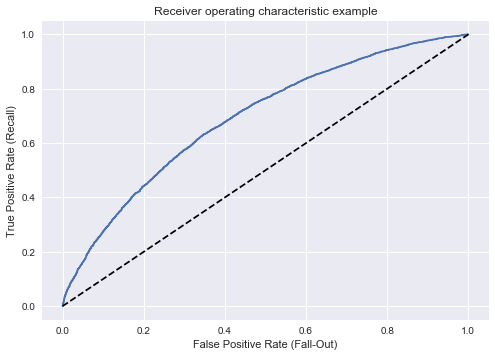

In [29]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds=roc_curve(y_train,logreg.decision_function(x_train_std))

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver operating characteristic example')
plt.show()


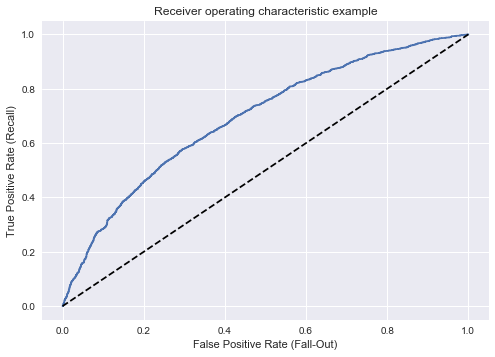

In [30]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds=roc_curve(y_test,logreg.decision_function(x_test_std))

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver operating characteristic example')
plt.show()


# decisiontree

In [31]:
from sklearn.tree import DecisionTreeClassifier

tree1 = DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=0).fit(x_train_std, y_train)

In [32]:
y_pred=tree1.predict(x_test_std)

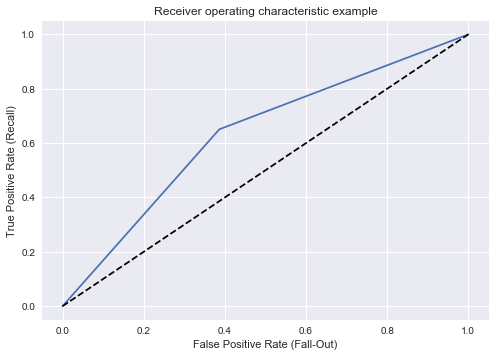

In [33]:
fpr,tpr,thresholds=roc_curve(y_test,y_pred)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver operating characteristic example')
plt.show()

In [34]:
predicted = cross_validation.cross_val_predict(DecisionTreeClassifier(), x_train, y_train, cv=10)
scores = cross_validation.cross_val_score(DecisionTreeClassifier(), x_train, y_train, cv=10)
print (metrics.classification_report(y_train, predicted))
print(metrics.accuracy_score(y_train, predicted))


print('average score: {}'.format(scores.mean()))


             precision    recall  f1-score   support

          0       0.57      0.57      0.57      6283
          1       0.57      0.57      0.57      6237

avg / total       0.57      0.57      0.57     12520

0.569249201278
average score: 0.5725238610251047


In [35]:
from sklearn.svm import SVC
svc=SVC(kernel="linear").fit(x_train_std,y_train)
y_predict_svc=svc.predict(x_test_std)
print (metrics.classification_report(y_test,y_predict_svc))


             precision    recall  f1-score   support

          0       0.63      0.63      0.63      2660
          1       0.64      0.64      0.64      2706

avg / total       0.64      0.64      0.64      5366



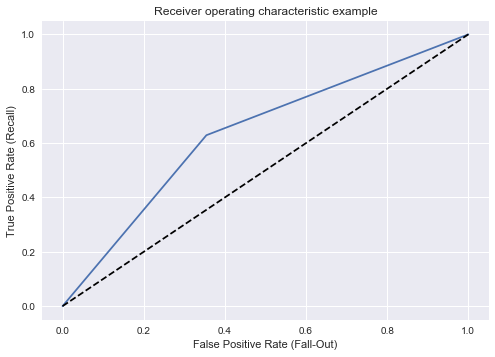

In [47]:
fpr,tpr,thresholds=roc_curve(y_test,y_predict_svc)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver operating characteristic example')
plt.show()

In [51]:
svc_rbf=SVC(kernel="rbf").fit(x_train_std,y_train)
y_predict_svc_rbf=svc_rbf.predict(x_test_std)
y_predict_svc_rbf_train=svc_rbf.predict(x_train_std)
print (metrics.classification_report(y_test,y_predict_svc_rbf))
print (metrics.classification_report(y_train,y_predict_svc_rbf_train))


             precision    recall  f1-score   support

          0       0.64      0.62      0.63      2660
          1       0.64      0.65      0.64      2706

avg / total       0.64      0.64      0.64      5366

             precision    recall  f1-score   support

          0       0.72      0.71      0.71      6283
          1       0.71      0.72      0.72      6237

avg / total       0.72      0.72      0.72     12520



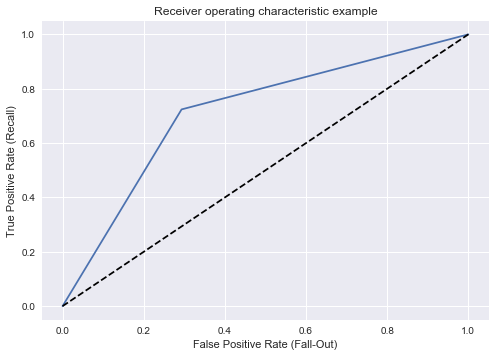

In [52]:
fpr,tpr,thresholds=roc_curve(y_train,y_predict_svc_rbf_train)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver operating characteristic example')
plt.show()

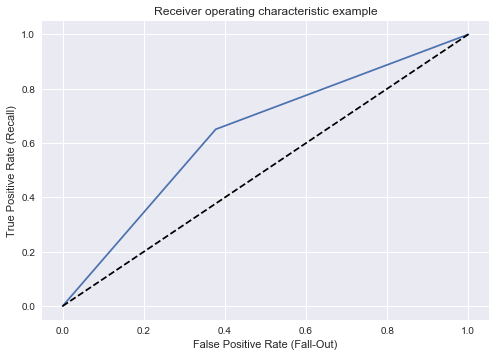

In [49]:
fpr,tpr,thresholds=roc_curve(y_test,y_predict_svc_rbf)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver operating characteristic example')
plt.show()

# 하이퍼 파라미터 튜닝

In [53]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

In [54]:
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(svm.SVC(kernel='rbf'),scoring='accuracy', param_grid=param_grid, cv=10)

In [ ]:
grid_search.fit(x_train_std,y_train)